### Load packages

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load datasets

In [7]:
# load dataset
df = pd.read_csv('../data/ADS_project_dataset2.csv', header=0, parse_dates=[0], squeeze=True)

In [27]:
# exclude rows with missing average temperature
df_temp = df[(df.Year >= 1960) & (df.Year <= 2012)].loc[:,['Country', 'Year', 'AveTemperature']]

### Define functions

In [202]:
def get_rsme(df, span, chart=False, chart_list=None):
    '''
    get RMSE for each span, and plot chart for countries in chart_list if chart is True
    
    '''  
    countr_list = list(df['Country'].unique())
    rsme_list = []
    df_master = pd.DataFrame()
    
    for i in country_list: 
        year = df[df['Country'] == i].sort_values('Year').Year
        series = df[df['Country'] == i].sort_values('Year').AveTemperature
        ewma = pd.ewma(series, span=span)
        df_comb = pd.DataFrame({'ewma': ewma, 'observed': series})
        
        if chart and (i in chart_list):
            df_comb.plot(title = i + ': observed vs. smoothed temperatures')
        
        df_comb['squared_error'] = (df_comb.ewma - df_comb.observed) ** 2
        df_comb['Country'] = i
        df_comb['Year'] =year
        rsme = np.sqrt(df_comb.squared_error.sum() / df_comb.shape[0])
        rsme_list.append(rsme)
        df_master = df_master.append(df_comb, ignore_index=True)
    
    rsme = np.sum(rsme_list) / len(rsme_list)
    return rsme, df_master

In [185]:
def find_best_span(df, span_list):
    '''
    cycle through a list containing spans and return corresponding RSME
    '''
    rmse_master_list = []
    for j in span_list:
        rsme, _ = get_rsme(df, j)
        rmse_master_list.append(rsme)
#         print('span=' + str(j) + ', rsme=' + str(rsme))
    return rmse_master_list

### Hyperparameter Search
Exponentially weighted moving average (EWMA) requires a hyperparameter alpha, which is often defined with a span. 10 years would be a typical span for smoothing temperature data, but we are validating this knowledge with a hyperparameter search on our temperature data in this section. Note that I am not looking for a hyperparameter that minimizes validation RMSE given EWMA is a smoothing method and there is no train-validation setup typically found in machine learning modeling. Rather, I am looking for a span with which gain in RMSE diminishes, and comparing the span against knowledge from domain experts.

In [186]:
# create a list of spans to get RMSE
span_list = [1] + list(range(5, 50, 5))

In [187]:
# get RMSE for spans
rmse = find_best_span(df_temp, span_list)

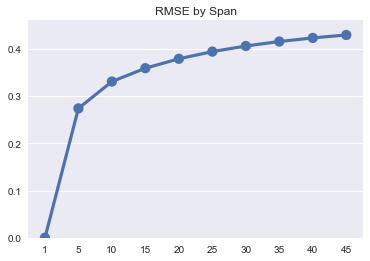

In [188]:
# plot spans and corresponding RMSE
plt.title('RMSE by Span')
g = sns.pointplot(x=span_list, y=rmse)
g.set(ylim=(0, None));

** FINDINGS: **
* The chart above indicates that gains in RMSE becomes stable around the span of 10. This validates domain knowledge and the span of 10 is used for our hyperparameter for the rest of the analysis.

### Modeling
In this section, I run EWMA for every country in the dataset using a span of 10 years, and create a dataset containing smoothed average temperatures, which will be used for hypothesis testings.

In [176]:
# create a list of countries to spot-check by plotting their observed and smoothed average temperatures
chart_list = ['Australia', 'Japan', 'United States of America']

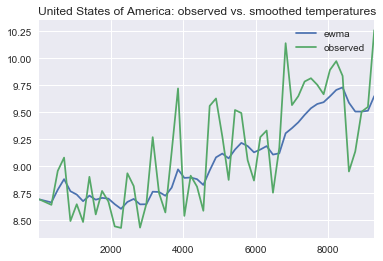

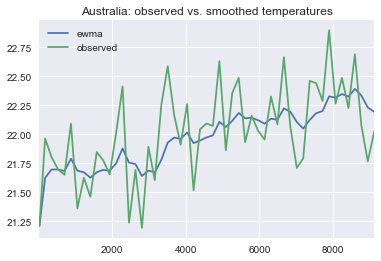

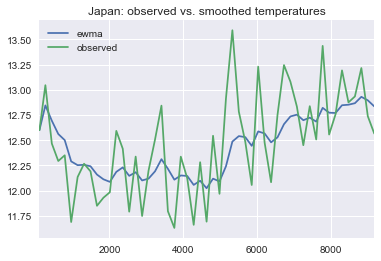

In [203]:
# create a dataset containing smoothed average temparatures using EWMA with a span of 10
rsme, df_master = get_rsme(df_temp, 10, chart=True, chart_list = chart_list)

In [196]:
rsme

0.3306388795940953

In [206]:
df_master.head()

,ewma,observed,squared_error,Country,Year
0,25.167250,25.167250,0.000000,Bahamas,1960
1,25.286325,25.383750,0.009492,Bahamas,1961
2,25.207236,25.089583,0.013842,Bahamas,1962
3,25.188819,25.151333,0.001405,Bahamas,1963
4,25.264993,25.454167,0.035787,Bahamas,1964


In [207]:
# save the dataset 
df_master.to_csv('../data/ewma.csv', index=False)